In [1]:
import pandas as pd
import numpy as np 
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder,LabelBinarizer
from sklearn.compose import ColumnTransformer,make_column_transformer

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report

from imblearn.pipeline import make_pipeline as imbl_pipe
from imblearn.over_sampling import SMOTE

#hyper-parameter tuning
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#importing models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix






In [2]:
churn_df = pd.read_csv(r"C:\Users\azhad\Downloads\Churn_Modelling.csv")

In [7]:
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Preprocessing

#### Changing the name of target column from 'Exited' to 'Churn'

In [8]:
churn_df= churn_df.rename(columns= {'Exited':'Churn'})

#### Checking the datatypes

In [9]:
churn_df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Churn                int64
dtype: object

#### Checking the null values

In [10]:
churn_df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Churn              0
dtype: int64

#### Checking the duplicates 

In [11]:
churn_df.duplicated().sum()

0

#### Dropping the RowNumber and Surname Column

In [12]:
churn_df.drop('RowNumber', axis= 1, inplace= True)

In [13]:
churn_df.drop('Surname', axis= 1, inplace= True)

#### Changing the dtype of target feature, IsActiveMember, hasCrCard and NumOfProducts from int to categorical

In [14]:
churn_df['Churn'] = churn_df['Churn'].astype('category')

In [15]:
churn_df['HasCrCard'] = churn_df['HasCrCard'].astype('category')

In [16]:
churn_df['IsActiveMember'] = churn_df['IsActiveMember'].astype('category')

In [17]:
churn_df['NumOfProducts'] = churn_df['NumOfProducts'].astype('category')

#### Data Quality Report for Numeric Features

In [18]:
churn_numeric= churn_df.select_dtypes(include= ['int','float'])

In [19]:
churn_stats= pd.DataFrame(churn_numeric.describe().transpose())


In [20]:
churn_stats

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


#### Checking the cardinality for numeric features

In [21]:
cardinality=[]

for i in churn_numeric.columns:
    cardinality.append(churn_numeric[i].nunique())
    

In [22]:
churn_stats['cardinality'] = cardinality

#### Changing the column names

In [23]:
churn_stats.columns= ['Count','Mean','Std Dev','Min','First Quart','Second Quart','Third Quart','Max', 'Cardinality']

In [24]:
churn_stats= churn_stats.applymap(lambda x: int(x))

In [25]:
churn_stats

,Count,Mean,Std Dev,Min,First Quart,Second Quart,Third Quart,Max,Cardinality
CustomerId,10000,15690940,71936,15565701,15628528,15690738,15753233,15815690,10000
CreditScore,10000,650,96,350,584,652,718,850,460
Age,10000,38,10,18,32,37,44,92,70
Tenure,10000,5,2,0,3,5,7,10,11
Balance,10000,76485,62397,0,0,97198,127644,250898,6382
EstimatedSalary,10000,100090,57510,11,51002,100193,149388,199992,9999


#### Dropping CustomerID as the cardinality is equal to the number of instances

In [26]:
churn_df.pop('CustomerId')

0       15634602
1       15647311
2       15619304
3       15701354
4       15737888
          ...   
9995    15606229
9996    15569892
9997    15584532
9998    15682355
9999    15628319
Name: CustomerId, Length: 10000, dtype: int64

#### Data Quality Report for Categorical Features

In [27]:
churn_categ= churn_df.select_dtypes(include= ['category','object'])

In [28]:
churn_categ_stats= pd.DataFrame(churn_categ.describe().transpose())

In [29]:
cardinality=[]

for i in churn_categ.columns:
    cardinality.append(churn_categ[i].nunique())
  

In [30]:
churn_categ_stats['cardinality']= cardinality

In [31]:
churn_categ_stats

,count,unique,top,freq,cardinality
Geography,10000,3,France,5014,3
Gender,10000,2,Male,5457,2
NumOfProducts,10000,4,1,5084,4
HasCrCard,10000,2,1,7055,2
IsActiveMember,10000,2,1,5151,2
Churn,10000,2,0,7963,2


In [32]:
mode= []

for i in churn_categ.columns:
    mode.append(stat.mode(churn_categ[i]))
 

In [33]:
churn_categ_stats['mode']= mode

In [34]:
churn_categ_stats

,count,unique,top,freq,cardinality,mode
Geography,10000,3,France,5014,3,France
Gender,10000,2,Male,5457,2,Male
NumOfProducts,10000,4,1,5084,4,1
HasCrCard,10000,2,1,7055,2,1
IsActiveMember,10000,2,1,5151,2,1
Churn,10000,2,0,7963,2,0


## Explonatory Data Analysis

#### Plotting Histograms for Numeric Features

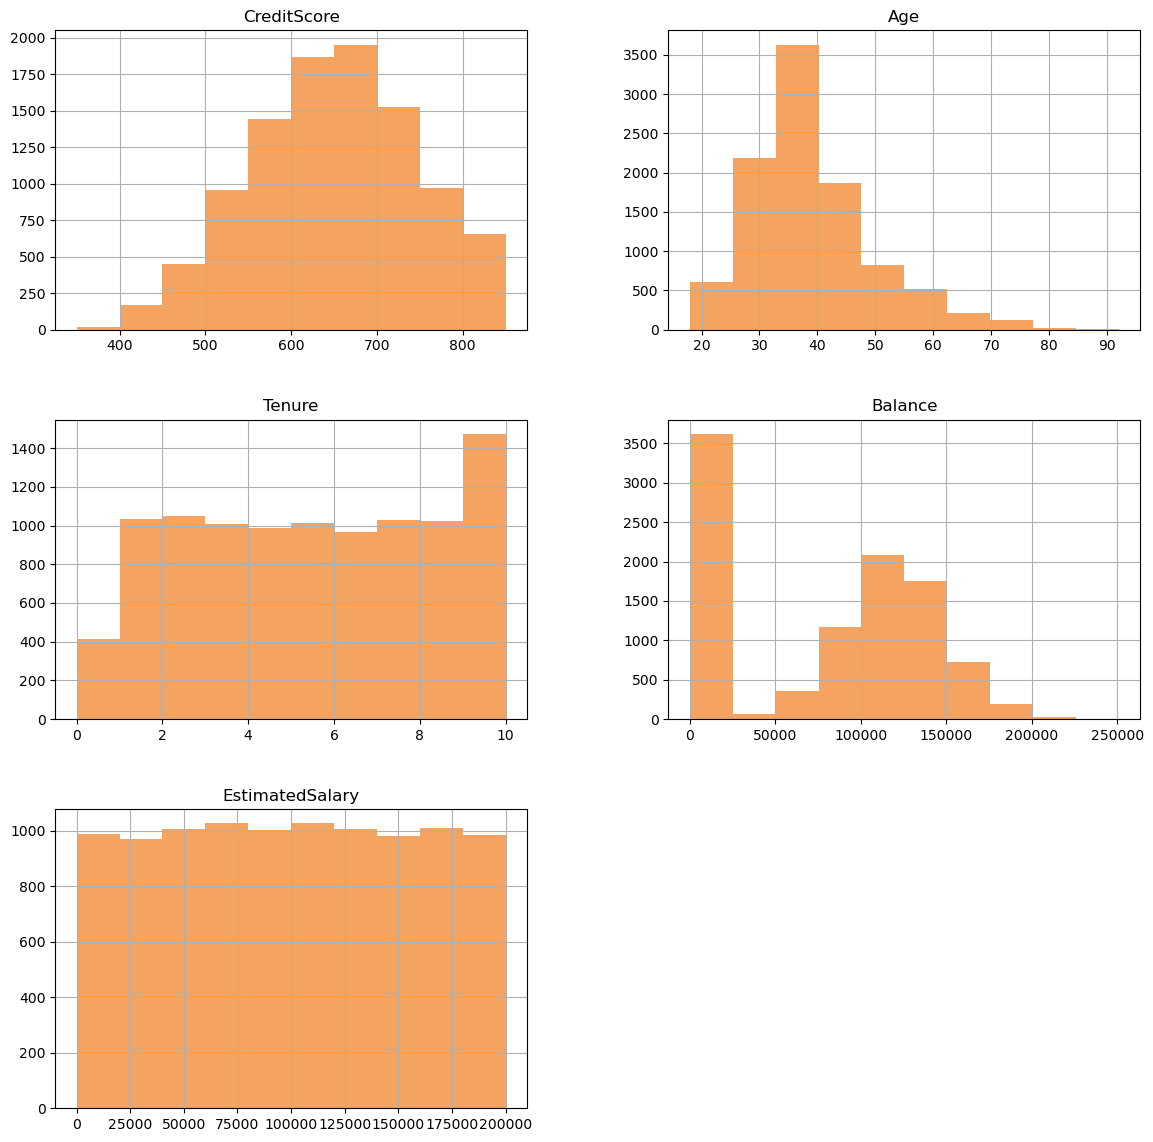

In [31]:
churn_df.hist(figsize=(14,14), color= 'sandybrown')

plt.show()

#### Plotting Countplot for categorical Features

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\si

<AxesSubplot:xlabel='Churn', ylabel='count'>

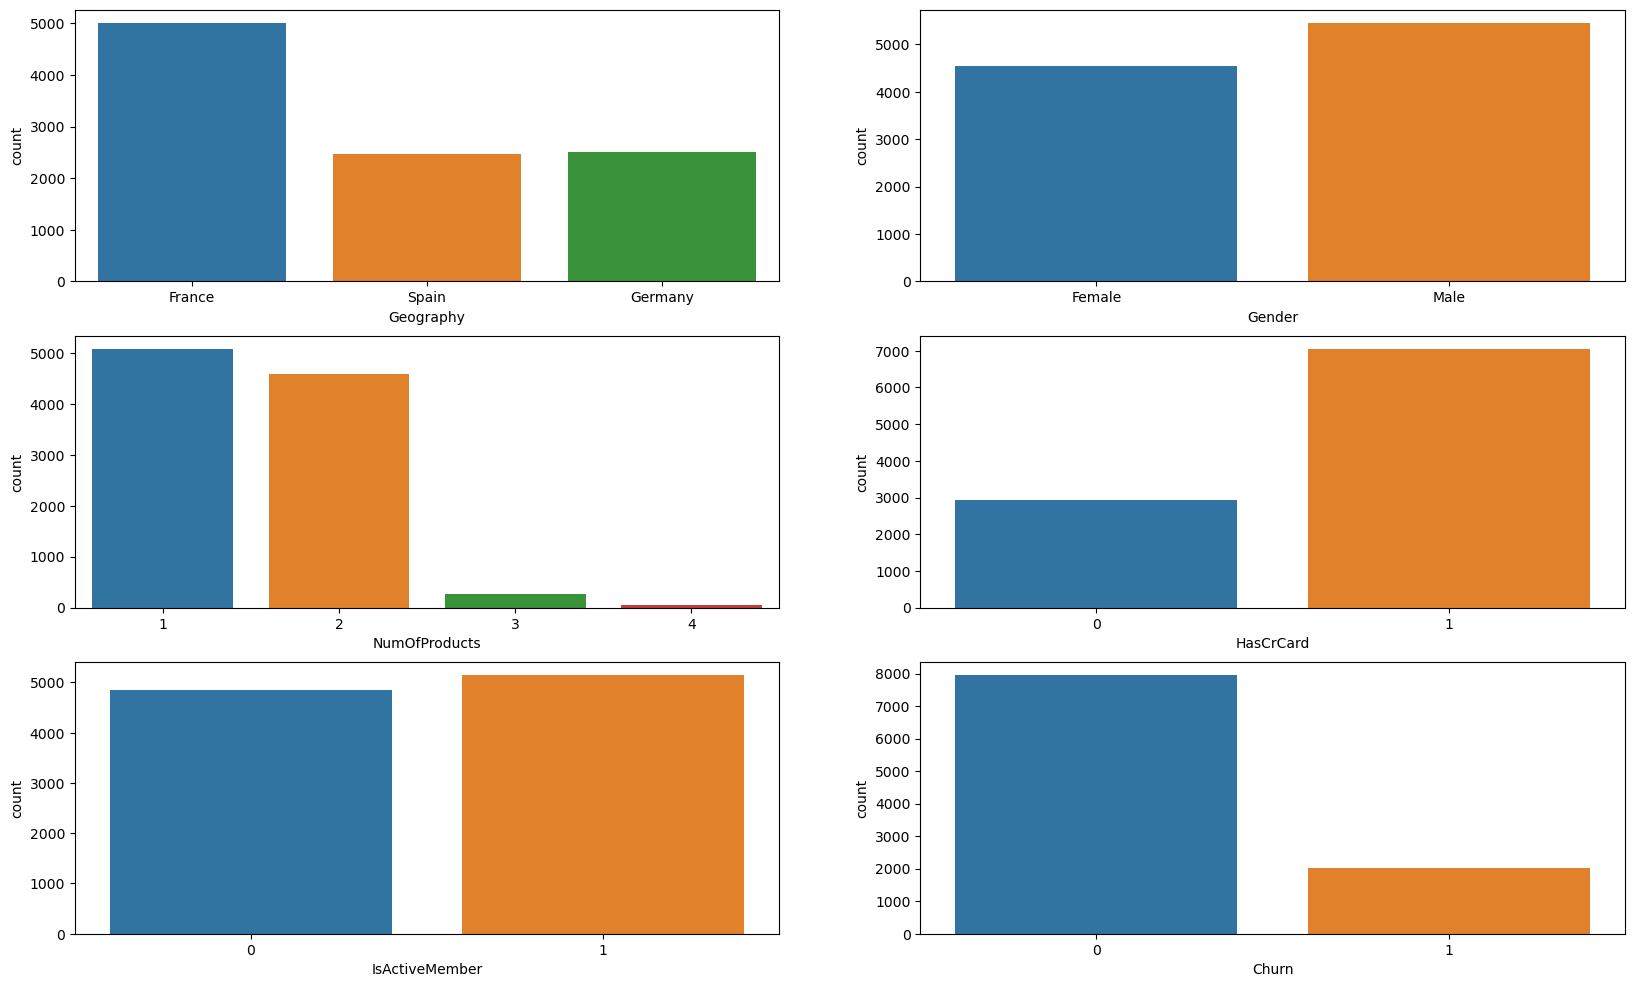

In [32]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.countplot(churn_df['Geography'], ax=axarr[0][0])
sns.countplot(churn_df['Gender'], ax=axarr[0][1])
sns.countplot(churn_df['NumOfProducts'], ax=axarr[1][0])  
sns.countplot(churn_df['HasCrCard'], ax=axarr[1][1]) 
sns.countplot(churn_df['IsActiveMember'], ax=axarr[2][0])  
sns.countplot(churn_df['Churn'], ax=axarr[2][1])

#### Plotting the KDE Plot for Balance wrt to Churn Feature

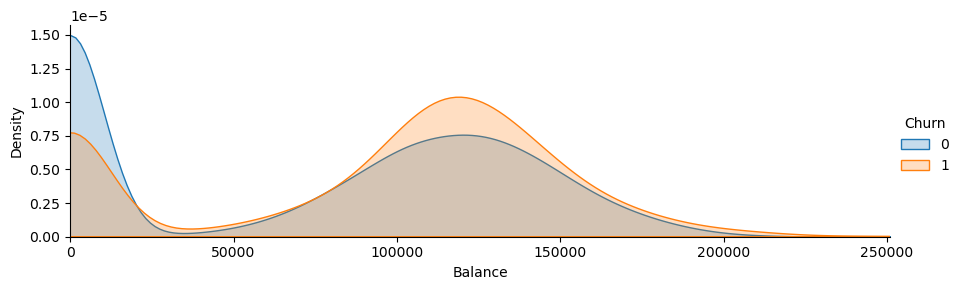

In [33]:
facet = sns.FacetGrid(churn_df, hue="Churn",aspect=3)
facet.map(sns.kdeplot,"Balance",shade= True)
facet.set(xlim=(0, churn_df["Balance"].max()))
facet.add_legend()
plt.show()

#### Churn Segmentation for Categorical Variables

#### Churn wrt Gender

In [34]:
churn_categ_gender = pd.DataFrame(churn_categ.groupby('Gender').Churn.value_counts())

In [35]:
churn_categ_gender.reset_index(inplace= True)

In [36]:
churn_categ_gender.columns= ['Gender','churned','Churn']

In [37]:
churn_categ_gender

,Gender,churned,Churn
0,Female,0,3404
1,Female,1,1139
2,Male,0,4559
3,Male,1,898


In [38]:
churn_categ_gender1 = pd.DataFrame(churn_categ.groupby('Gender').Churn.value_counts(normalize= True))

In [39]:
churn_categ_gender1.reset_index(inplace= True)

In [40]:
churn_categ_gender1['Churn'] = churn_categ_gender1['Churn'].apply(lambda x: round(x*100))

In [41]:
churn_categ_gender1.columns= ['Gender','churned','Churn']

In [42]:
churn_categ_gender1

,Gender,churned,Churn
0,Female,0,75
1,Female,1,25
2,Male,0,84
3,Male,1,16


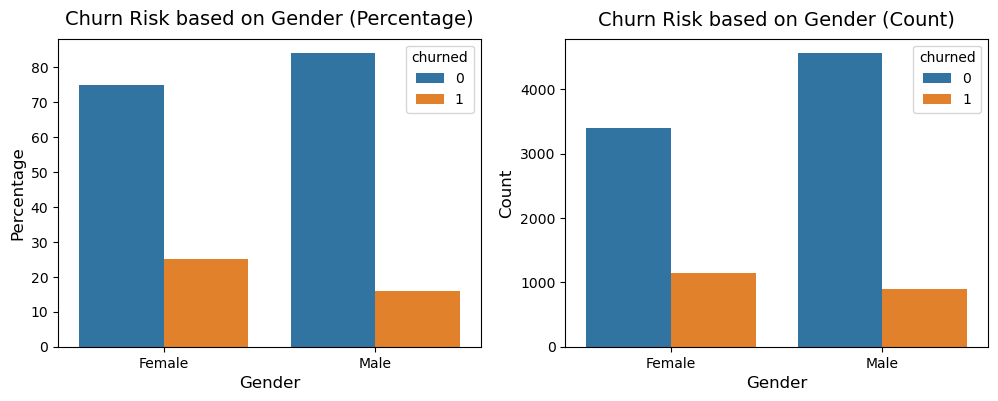

In [43]:
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(12, 4))

sns.barplot(data= churn_categ_gender1, x= 'Gender', y='Churn', hue= 'churned',ax=ax1)

ax1.set_title('Churn Risk based on Gender (Percentage)', fontsize=14, pad=10)
ax1.set_ylabel('Percentage',size=12)
ax1.set_xlabel('Gender', size=12)

sns.barplot(data=churn_categ_gender, x= 'Gender', y='Churn', hue= 'churned',ax=ax2)

ax2.set_title('Churn Risk based on Gender (Count)', fontsize=14, pad=10)
ax2.set_ylabel('Count',size=12)
ax2.set_xlabel('Gender', size=12)
plt.show()

#### Churn wrt Geography

In [44]:
churn_categ_geography = pd.DataFrame(churn_categ.groupby('Geography').Churn.value_counts())

In [45]:
churn_categ_geography.reset_index(inplace= True)

In [46]:
churn_categ_geography.columns= ['Geography','churned','Churn']

In [47]:
churn_categ_geography

,Geography,churned,Churn
0,France,0,4204
1,France,1,810
2,Germany,0,1695
3,Germany,1,814
4,Spain,0,2064
5,Spain,1,413


In [48]:
churn_categ_geography1 = pd.DataFrame(churn_categ.groupby('Geography').Churn.value_counts(normalize= True))

In [49]:
churn_categ_geography1.reset_index(inplace= True)

In [50]:
churn_categ_geography1['Churn'] = churn_categ_geography1['Churn'].apply(lambda x: round(x*100))

In [51]:
churn_categ_geography1.columns= ['Geography','churned','Churn']

In [52]:
churn_categ_geography1

,Geography,churned,Churn
0,France,0,84
1,France,1,16
2,Germany,0,68
3,Germany,1,32
4,Spain,0,83
5,Spain,1,17


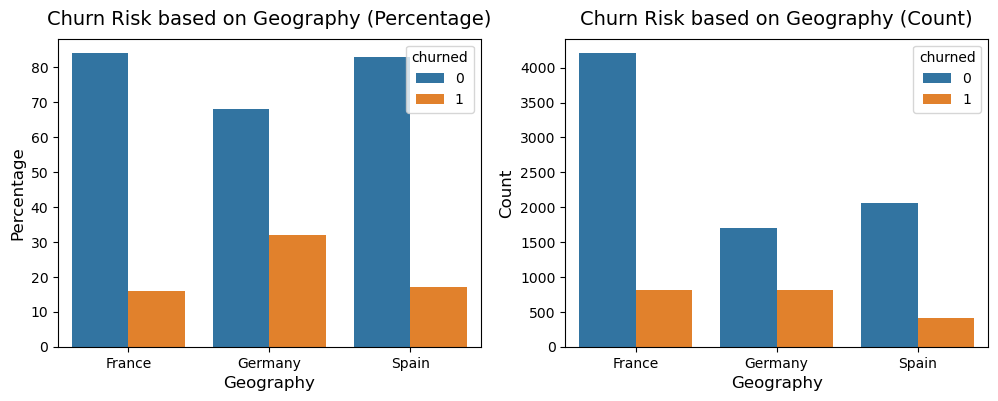

In [53]:
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(12, 4))

sns.barplot(data= churn_categ_geography1, x= 'Geography', y='Churn', hue= 'churned',ax=ax1)

ax1.set_title('Churn Risk based on Geography (Percentage)', fontsize=14, pad=10)
ax1.set_ylabel('Percentage',size=12)
ax1.set_xlabel('Geography', size=12)

sns.barplot(data=churn_categ_geography, x= 'Geography', y='Churn', hue= 'churned',ax=ax2)

ax2.set_title('Churn Risk based on Geography (Count)', fontsize=14, pad=10)
ax2.set_ylabel('Count',size=12)
ax2.set_xlabel('Geography', size=12)
plt.show()

#### Churn wrt Active Member

In [54]:
churn_categ_activemember = pd.DataFrame(churn_categ.groupby('IsActiveMember').Churn.value_counts(normalize= True))

In [55]:
churn_categ_activemember.reset_index(inplace= True)

In [56]:
churn_categ_activemember['Churn'] = churn_categ_activemember['Churn'].apply(lambda x: round(x*100))

In [57]:
churn_categ_activemember.columns= ['IsActiveMember','churned','Churn']

In [58]:
churn_categ_activemember

,IsActiveMember,churned,Churn
0,0,0,73
1,0,1,27
2,1,0,86
3,1,1,14


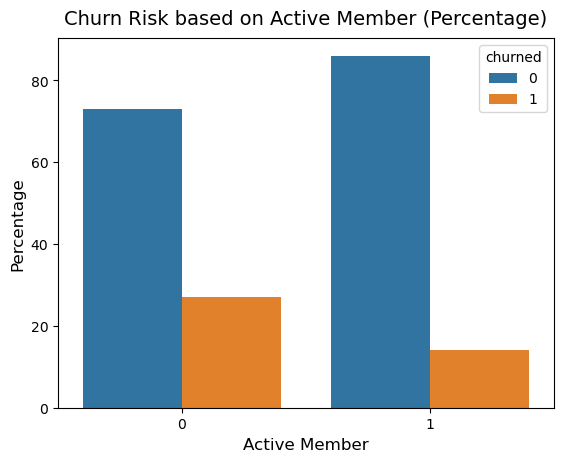

In [59]:
sns.barplot(data= churn_categ_activemember, x= 'IsActiveMember', y='Churn', hue= 'churned')

plt.title('Churn Risk based on Active Member (Percentage)', fontsize=14, pad=10)
plt.ylabel('Percentage',size=12)
plt.xlabel('Active Member', size=12)
plt.show()

#### Churn wrt Product Number

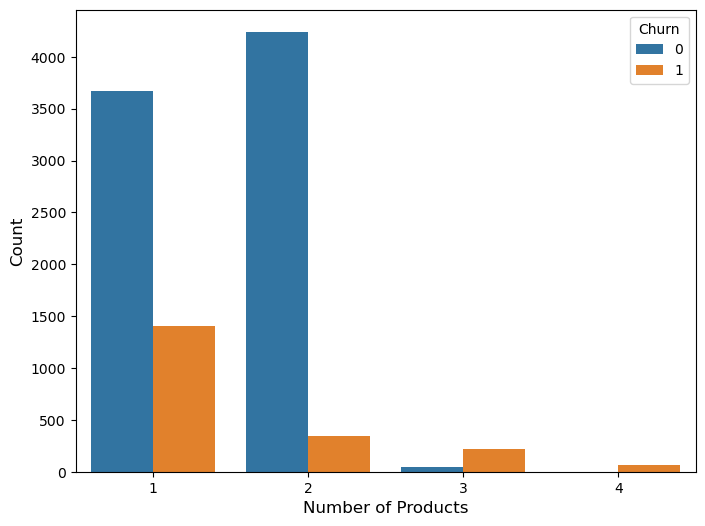

In [60]:
plt.figure(figsize=(8,6))
sns.countplot(data= churn_df, x='NumOfProducts', hue= 'Churn')
plt.xlabel("Number of Products", size= 12)
plt.ylabel("Count", size= 12)
plt.show()

#### Churn wrt Credit Card

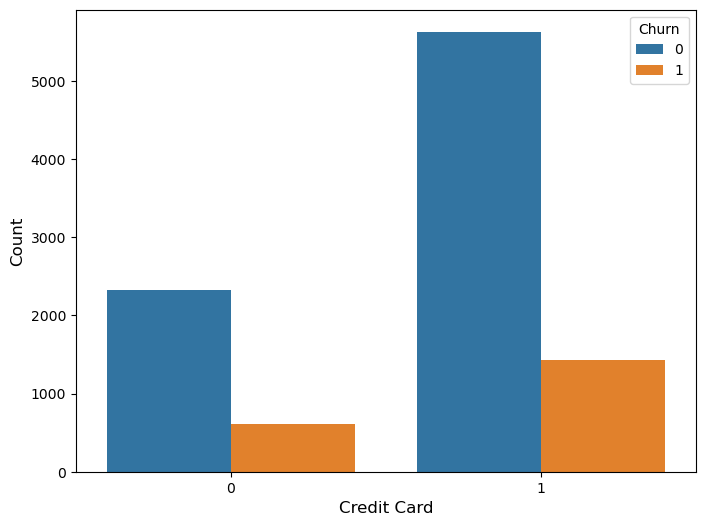

In [61]:
plt.figure(figsize=(8,6))
sns.countplot(data= churn_df, x='HasCrCard', hue= 'Churn')
plt.xlabel("Credit Card", size= 12)
plt.ylabel("Count", size= 12)
plt.show()

#### Checking the Correlation between various

In [62]:
corr_df=churn_df.select_dtypes(include=['int','float','category'])
corr_df['Churn'] = corr_df['Churn'].astype('int')

<AxesSubplot:>

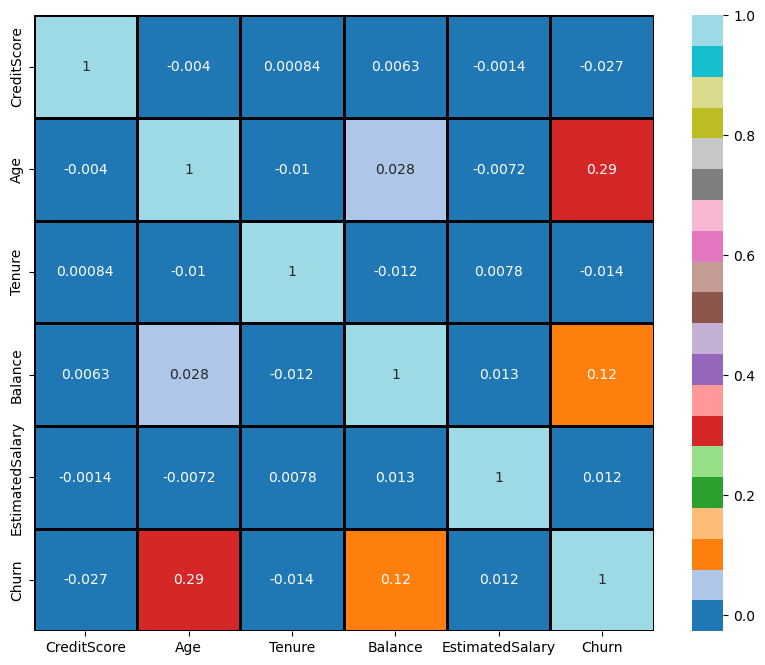

In [63]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), cmap='tab20', linewidth= 2, linecolor= 'black', annot= True)

#### Analysing min and max values for top three features as per correlation values

In [64]:
top_features= pd.pivot_table(data= churn_df, columns= 'Churn', aggfunc= [np.min, np.max], values=['Age', 'Balance','EstimatedSalary'])

In [65]:
top_features.columns =[('Min','Retained'),('Min','Churn'),('Max','Retained'),('Max','Churn')]

In [66]:
top_features

,"(Min, Retained)","(Min, Churn)","(Max, Retained)","(Max, Churn)"
Age,18.00,18.00,92.00,84.00
Balance,0.00,0.00,221532.80,250898.09
EstimatedSalary,90.07,11.58,199992.48,199808.10


#### Checking the Outliers

<AxesSubplot:xlabel='Churn', ylabel='EstimatedSalary'>

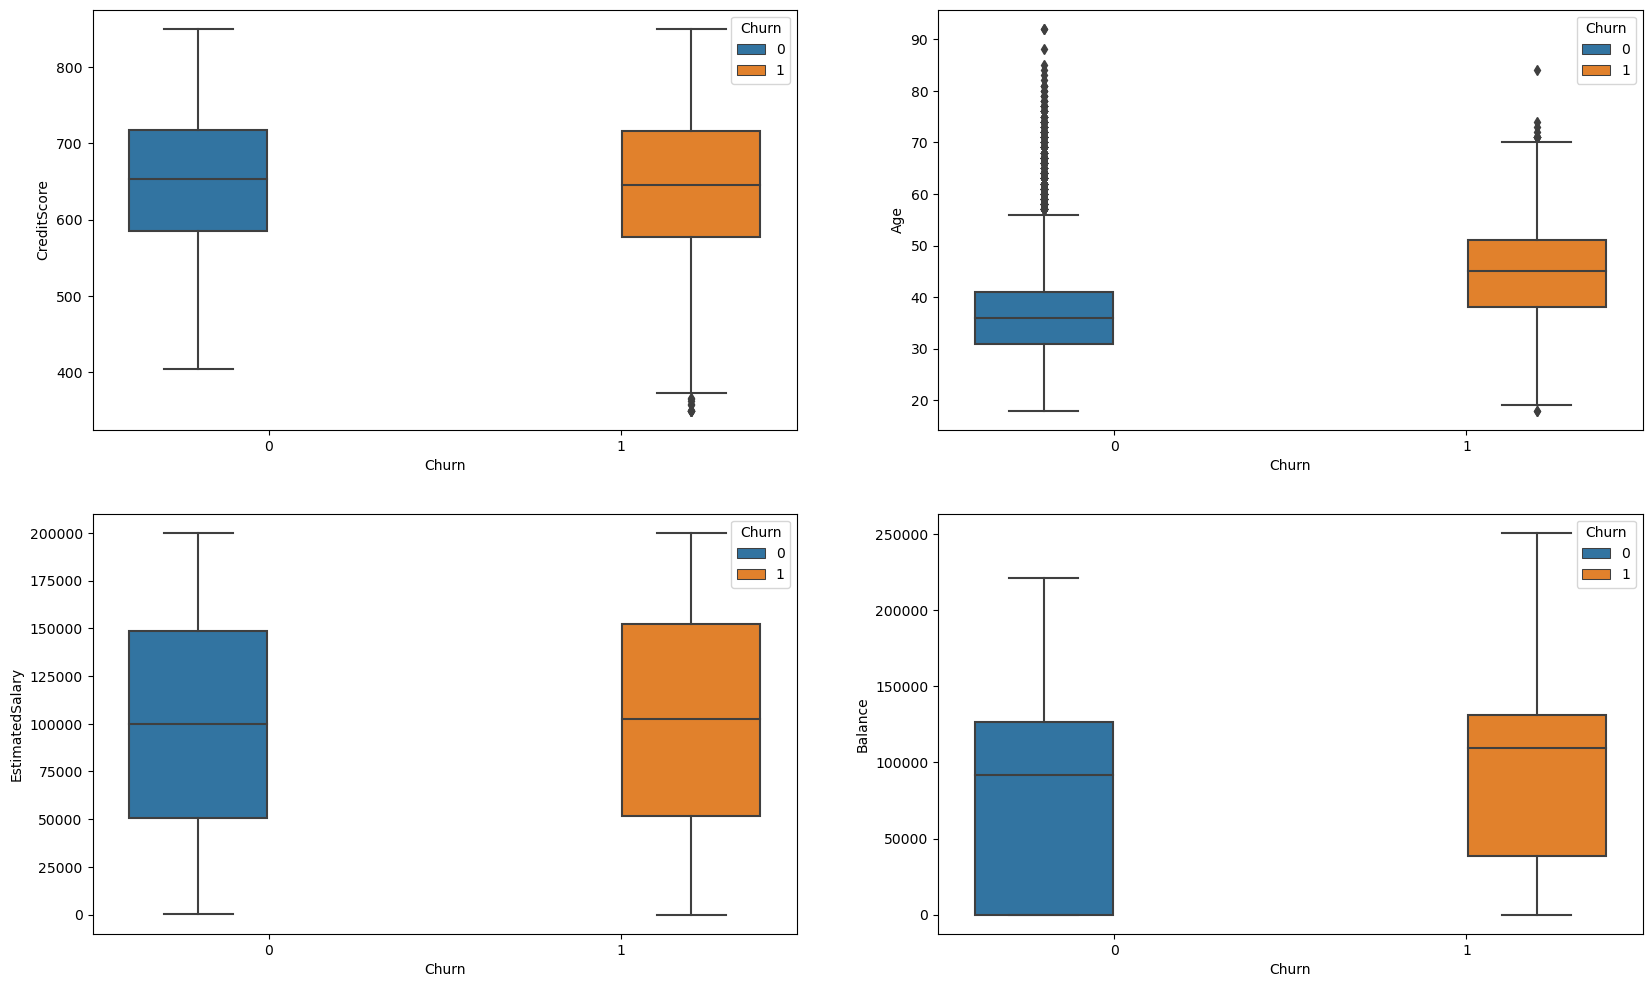

In [67]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Churn', hue = 'Churn',data = churn_df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Churn', hue = 'Churn',data = churn_df , ax=axarr[0][1])
sns.boxplot(y='Balance',x = 'Churn', hue = 'Churn',data = churn_df, ax=axarr[1][1])
sns.boxplot(y='EstimatedSalary',x = 'Churn', hue = 'Churn',data = churn_df, ax=axarr[1][0])

#### Outlier Clamping

In [68]:
def outlier_func(i):
    
    q1= np.percentile(i, 25)
    q3= np.percentile(i,75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)
    
    return [lower, upper]


In [69]:
col= ["CreditScore","Balance","EstimatedSalary","Age"]
for features in col:
    lower,upper = outlier_func(churn_df[features])
    churn_df[features]= churn_df[features].clip(upper= upper, lower=lower, axis= 0)
    if np.any(churn_df[features] > upper) or np.any(churn_df[features] < lower):
        print(features,"yes")
    else:
        print(features, "no")
    
    


CreditScore no
Balance no
EstimatedSalary no
Age no


### Class Imbalance

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


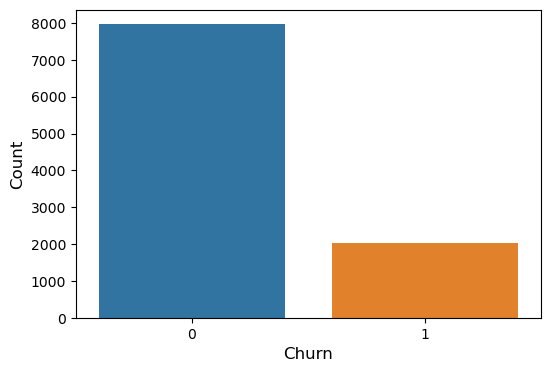

In [70]:
plt.figure(figsize=(6,4))
sns.countplot(churn_df['Churn'])
plt.xlabel("Churn", size= 12)
plt.ylabel("Count", size= 12)
plt.show()

#### Estimated Salary WRT Location

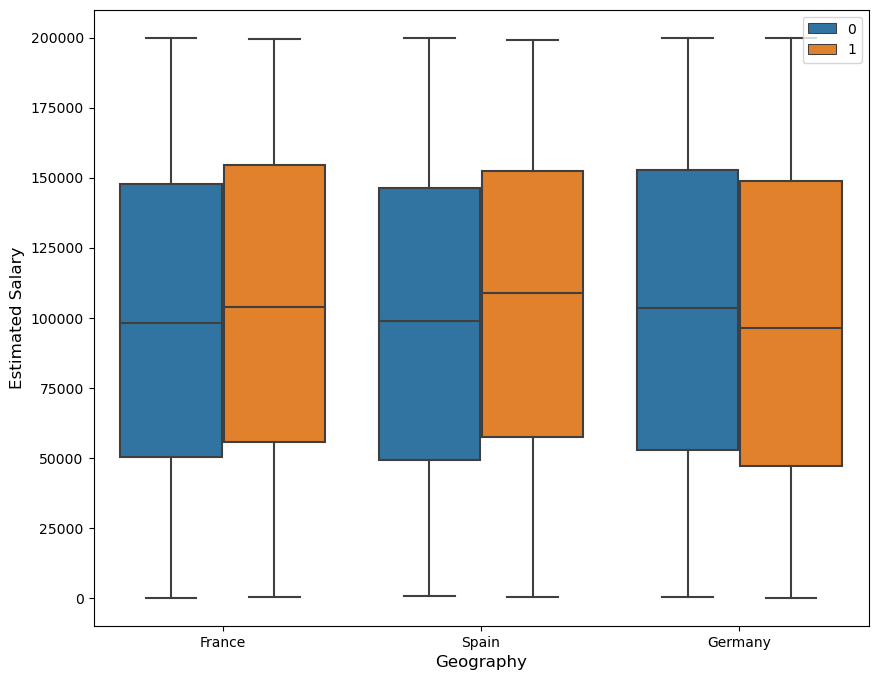

In [71]:
plt.figure(figsize=(10,8))
sns.boxplot(data= churn_df, x='Geography',y='EstimatedSalary', hue='Churn')
plt.xlabel("Geography", size= 12)
plt.ylabel("Estimated Salary", size= 12)
plt.legend(loc='upper right')
plt.show()

### Pair Plot

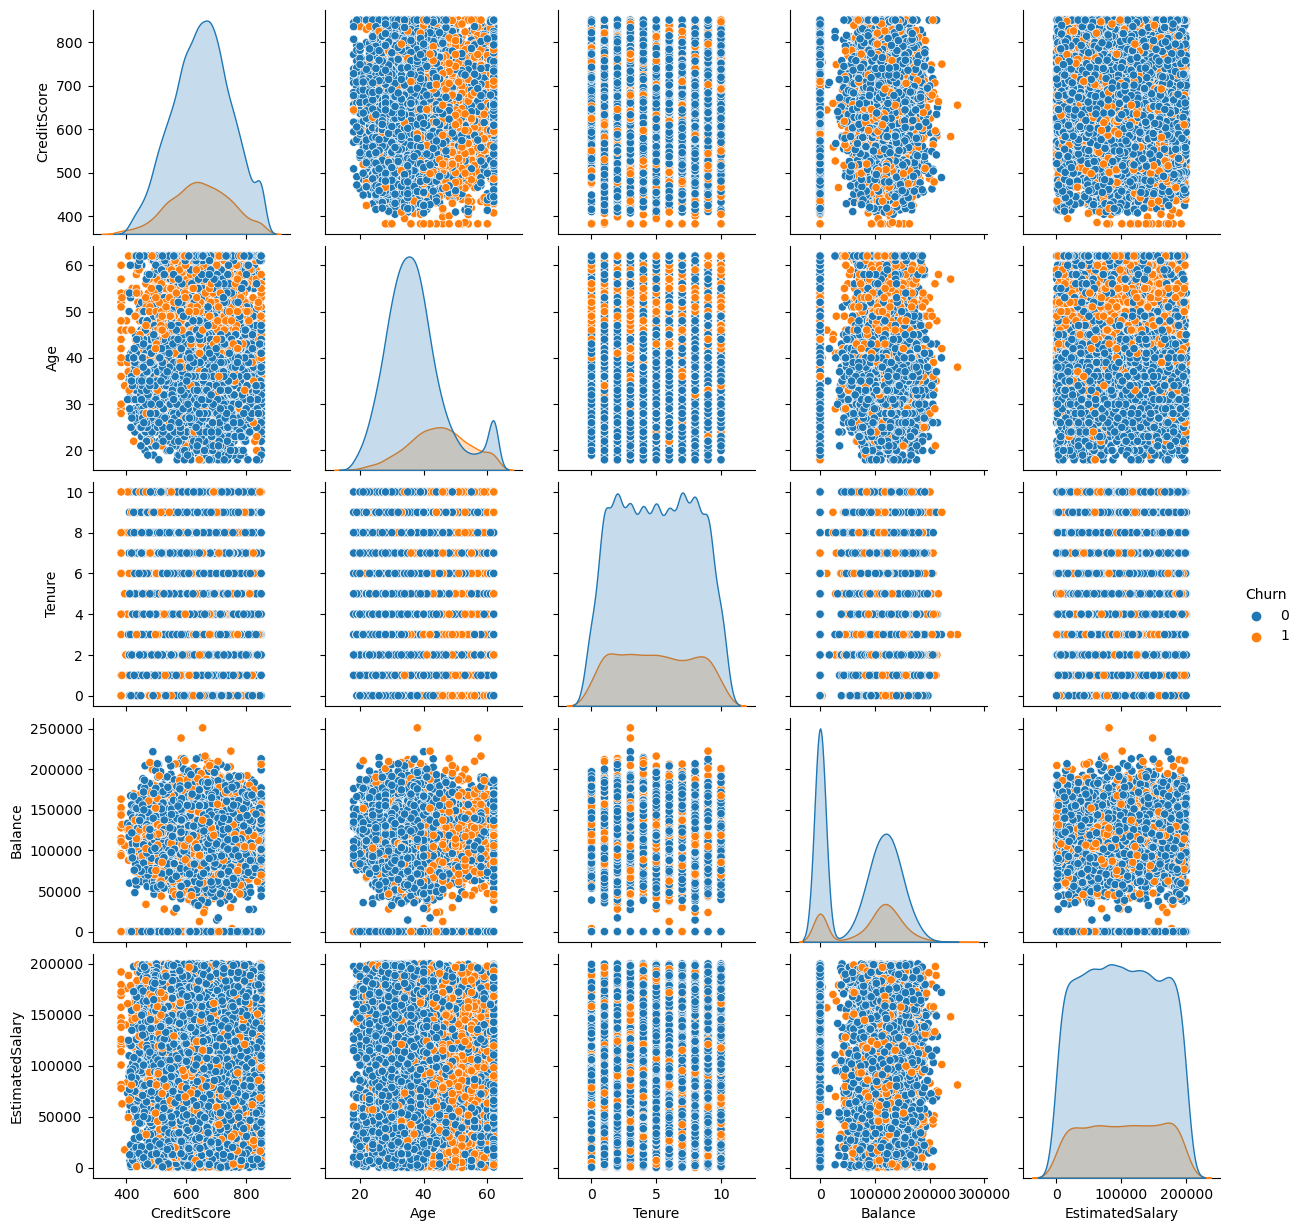

In [72]:
sns.pairplot(data= churn_df, hue= "Churn")

#### Reduced Pair Plot

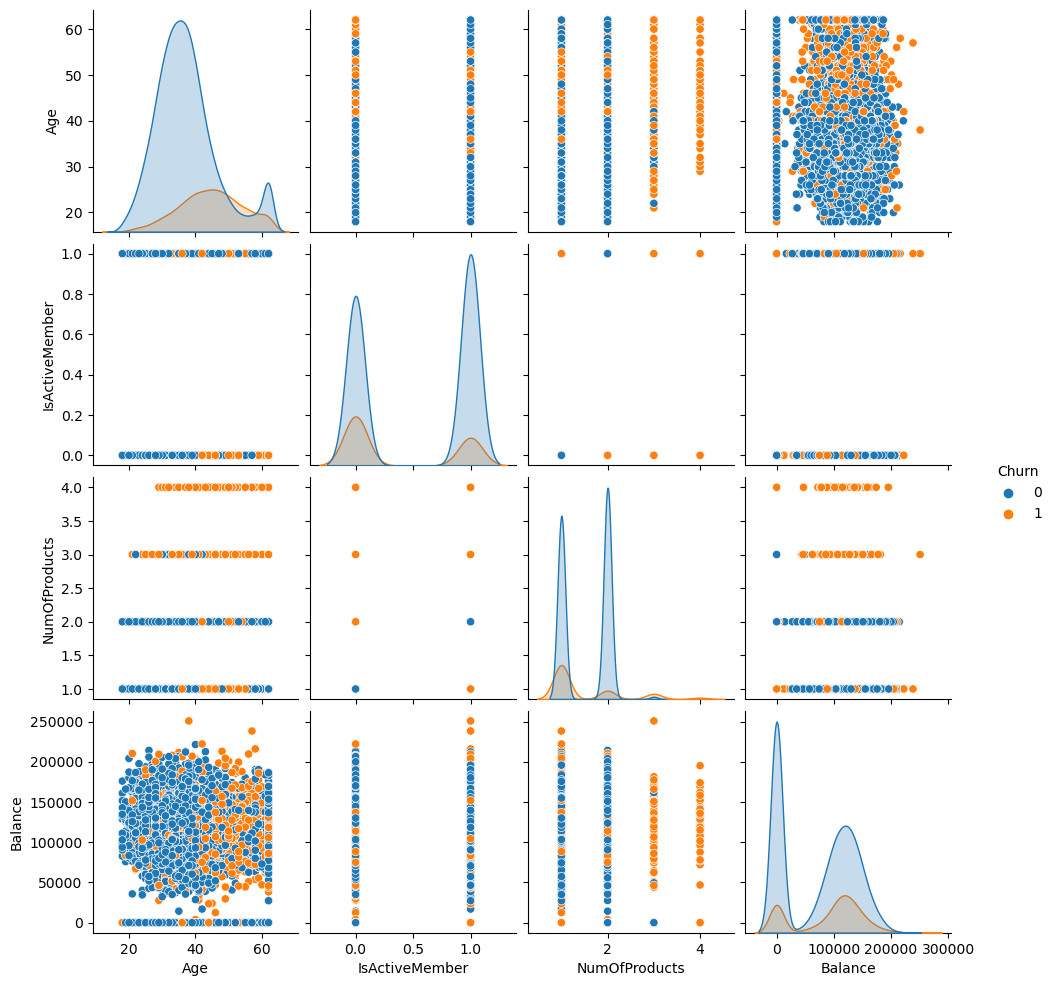

In [73]:
churned_df= churn_df.copy()
churned_df['IsActiveMember']= churned_df['IsActiveMember'].astype('int')
churned_df['NumOfProducts']= churned_df['NumOfProducts'].astype('int')
sns.pairplot(churned_df, hue='Churn',vars=['Age', 'IsActiveMember', 'NumOfProducts', 'Balance'])



## Analytical Base Table

In [74]:
abt= churn_df.head()
abt

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,619.0,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,608.0,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,502.0,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,699.0,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,850.0,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


## Feature Engineering

### Encoding the Categorical Data and Scaling the Numeric Data

In [35]:
X= churn_df.iloc[:,:-1].values
X #descriptive features

array([[619, 'France', 'Female', ..., 1, 1, 101348.88],
       [608, 'Spain', 'Female', ..., 0, 1, 112542.58],
       [502, 'France', 'Female', ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 'Female', ..., 0, 1, 42085.58],
       [772, 'Germany', 'Male', ..., 1, 0, 92888.52],
       [792, 'France', 'Female', ..., 1, 0, 38190.78]], dtype=object)

In [36]:
Y= churn_df.iloc[:,-1].values
Y #target features

[1, 0, 1, 0, 0, ..., 0, 0, 1, 1, 0]
Length: 10000
Categories (2, int64): [0, 1]

In [37]:
preprocessing = make_column_transformer( (MinMaxScaler(), [0, 3, 4, 5, 6, 7, 8, 9]),(OneHotEncoder(sparse=False,drop= 'first'), [1,2]))

In [38]:
preprocessing

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 [1, 2])])

In [39]:
X_preprocessed = preprocessing.fit_transform(X)

print(X_preprocessed.shape)

(10000, 11)


### Encoding the Target Data

In [40]:
label_binarizer = LabelBinarizer()

Y= label_binarizer.fit_transform(Y)


## Modelling 

#### Splitting the data into test and train

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, Y,test_size=0.3, random_state=32,
                                                    stratify= churn_df.Churn)

# Print number of observations in X_train, X_test, y_train, and y_test
print(X_train.shape, y_train.shape)

(7000, 11) (7000, 1)


### Logistic Regression

In [82]:
### creating the pipeline for data augmentation and logistic regression

In [83]:
lr_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),LogisticRegression(random_state=32))

lr_model

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('logisticregression', LogisticRegression(random_state=32))])

In [84]:
lr_param_grid = {'logisticregression__C' : [0.01, 0.05, 0.1, 0.5, 1, 5],
                 'logisticregression__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']} 
# Ridge Regularisation

lr_gridsearch = GridSearchCV(lr_model, lr_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [85]:
lr_gridsearch

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=32))]),
             param_grid={'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'logisticregression__solver': ['liblinear',
                                                        'newton-cg', 'lbfgs',
                                                        'sag', 'saga']},
             scoring='accuracy', verbose=3)

In [86]:
lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.689 total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.704 total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.700 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.698 total time=   0.0s
[CV 5/5] END logisticregression__C=0.01, logisticregression__solver=liblinear;, score=0.695 total time=   0.0s
[CV 1/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.699 total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.714 total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__solver=newton-cg;, score=0.706 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=32))]),
             param_grid={'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'logisticregression__solver': ['liblinear',
                                                        'newton-cg', 'lbfgs',
                                                        'sag', 'saga']},
             scoring='accuracy', verbose=3)

In [87]:
lr_results = pd.DataFrame(lr_gridsearch.cv_results_['params'])

In [88]:
lr_results['test_score'] = lr_gridsearch.cv_results_['mean_test_score']

In [89]:
lr_results

,logisticregression__C,logisticregression__solver,test_score
0,0.01,liblinear,0.697286
1,0.01,newton-cg,0.705143
2,0.01,lbfgs,0.705143
3,0.01,sag,0.705000
4,0.01,saga,0.705000
5,0.05,liblinear,0.709286
6,0.05,newton-cg,0.712143
7,0.05,lbfgs,0.712143
8,0.05,sag,0.712143
9,0.05,saga,0.712143


<function matplotlib.pyplot.show(close=None, block=None)>

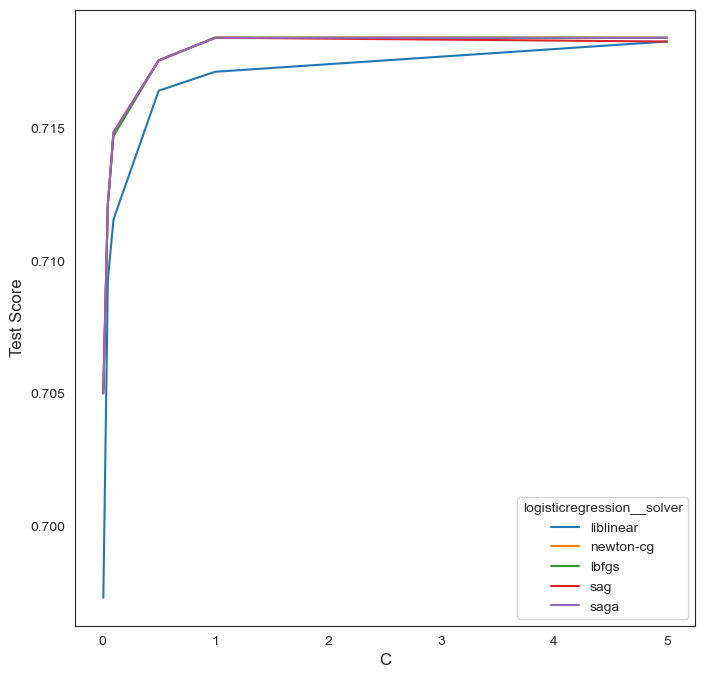

In [90]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.lineplot(data= lr_results,x='logisticregression__C',y='test_score',hue='logisticregression__solver')
plt.xlabel('C', size= 12)
plt.ylabel('Test Score', size= 12)
plt.show

In [91]:
print(lr_gridsearch.best_params_)

{'logisticregression__C': 1, 'logisticregression__solver': 'newton-cg'}


In [92]:
lr_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),
                  LogisticRegression(random_state=32,solver= 'newton-cg',C= 5 ))

In [93]:
lr_clf= lr_clf.fit(X_train,y_train)

In [94]:
import pickle

In [95]:
with open('logreg_pkl', 'wb') as files:
    pickle.dump(lr_clf, files)

### KNeighbors Classifier

In [96]:
knn_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),KNeighborsClassifier())

In [97]:
from sklearn.model_selection import GridSearchCV
kn_param_grid = {
    'kneighborsclassifier__n_neighbors' : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'kneighborsclassifier__weights' : ['uniform', 'distance'],
    'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'kneighborsclassifier__p' : [1,2]
}
knn_gridsearch = GridSearchCV(knn_model, kn_param_grid, verbose=3, cv= 5, scoring='accuracy', n_jobs=-1)

In [98]:
knn_gridsearch

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8,
                                                               9, 10, 11, 12,
                                                               13, 14, 15, 16,
                                                               17, 18, 19, 20],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy', verbose=3)

In [99]:
knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8,
                                                               9, 10, 11, 12,
                                                               13, 14, 15, 16,
                                                               17, 18, 19, 20],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy', verbose=3)

In [100]:
knn_results = pd.DataFrame(knn_gridsearch.cv_results_['params'])

In [101]:
knn_results['test_score'] = knn_gridsearch.cv_results_['mean_test_score']

In [102]:
knn_results

,kneighborsclassifier__algorithm,kneighborsclassifier__n_neighbors,kneighborsclassifier__p,kneighborsclassifier__weights,test_score
0,auto,3,1,uniform,0.747000
1,auto,3,1,distance,0.748429
2,auto,3,2,uniform,0.735429
3,auto,3,2,distance,0.736857
4,auto,4,1,uniform,0.770857
...,...,...,...,...,...
283,brute,19,2,distance,0.727000
284,brute,20,1,uniform,0.754857
285,brute,20,1,distance,0.747286
286,brute,20,2,uniform,0.737286


In [103]:
knn_results['metric'] = knn_results['kneighborsclassifier__p'].replace([1,2], ["Manhattan", "Euclidean"])
knn_results

,kneighborsclassifier__algorithm,kneighborsclassifier__n_neighbors,kneighborsclassifier__p,kneighborsclassifier__weights,test_score,metric
0,auto,3,1,uniform,0.747000,Manhattan
1,auto,3,1,distance,0.748429,Manhattan
2,auto,3,2,uniform,0.735429,Euclidean
3,auto,3,2,distance,0.736857,Euclidean
4,auto,4,1,uniform,0.770857,Manhattan
...,...,...,...,...,...,...
283,brute,19,2,distance,0.727000,Euclidean
284,brute,20,1,uniform,0.754857,Manhattan
285,brute,20,1,distance,0.747286,Manhattan
286,brute,20,2,uniform,0.737286,Euclidean


<function matplotlib.pyplot.show(close=None, block=None)>

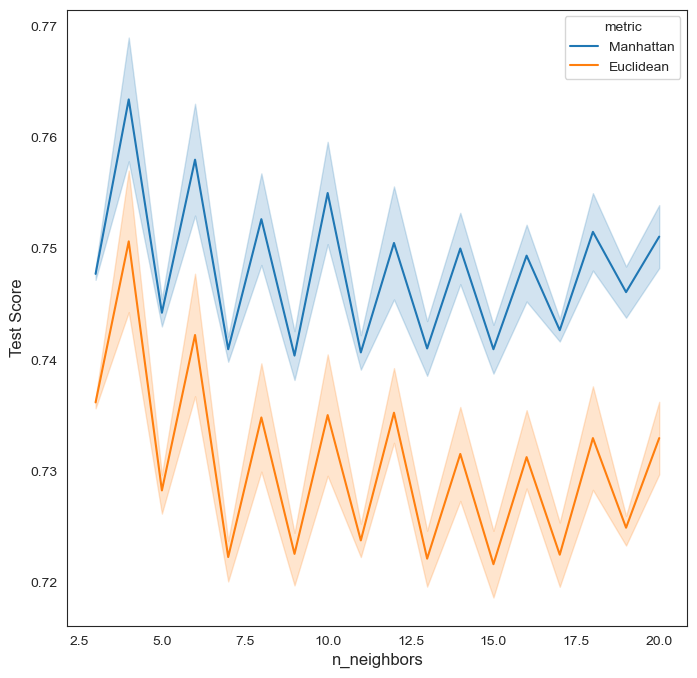

In [104]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.lineplot(data= knn_results,x='kneighborsclassifier__n_neighbors',y='test_score',hue='metric')
plt.xlabel('n_neighbors', size= 12)
plt.ylabel('Test Score', size= 12)
plt.show

In [105]:
print(knn_gridsearch.best_params_)

{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}


In [106]:
knn_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),
                   KNeighborsClassifier(algorithm='auto', n_neighbors= 4, p= 1, weights= 'uniform'))

In [107]:
knn_clf= knn_clf.fit(X_train,y_train)

In [108]:
with open('knn_pkl', 'wb') as files:
    pickle.dump(knn_clf, files)

## Decision Tree Classifier

In [109]:
dt_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),DecisionTreeClassifier(random_state=32))

dt_model

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=32))])

In [110]:
dt_param_grid = {
            'decisiontreeclassifier__max_leaf_nodes': [10, 20, 30], 
            'decisiontreeclassifier__min_samples_split': [3, 4],
            'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [4,6,8,10]
    
            }

dt_gridsearch = GridSearchCV(dt_model, dt_param_grid, verbose=3, cv= 5, scoring='accuracy', n_jobs=-1)

In [111]:
dt_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=32))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [4, 6, 8, 10],
                         'decisiontreeclassifier__max_leaf_nodes': [10, 20, 30],
                         'decisiontreeclassifier__min_samples_split': [3, 4]},
             scoring='accuracy', verbose=3)

In [112]:
dt_results = pd.DataFrame(dt_gridsearch.cv_results_['params'])

In [113]:
dt_results['test_score'] = dt_gridsearch.cv_results_['mean_test_score']

In [114]:
dt_results

,decisiontreeclassifier__criterion,decisiontreeclassifier__max_depth,decisiontreeclassifier__max_leaf_nodes,decisiontreeclassifier__min_samples_split,test_score
0,gini,4,10,3,0.804143
1,gini,4,10,4,0.804143
2,gini,4,20,3,0.806571
3,gini,4,20,4,0.806571
4,gini,4,30,3,0.806571
5,gini,4,30,4,0.806571
6,gini,6,10,3,0.783286
7,gini,6,10,4,0.783286
8,gini,6,20,3,0.802429
9,gini,6,20,4,0.802429


In [115]:
train_accuracies = {}
test_accuracies = {}
val = [2,4,6,8,10,12,14]
for v in val:    
    dtt = DecisionTreeClassifier(max_depth= v)   
    dtt.fit(X_train, y_train)    
    train_accuracies[v] = dtt.score(X_train, y_train)    
    test_accuracies[v] = dtt.score(X_test, y_test)


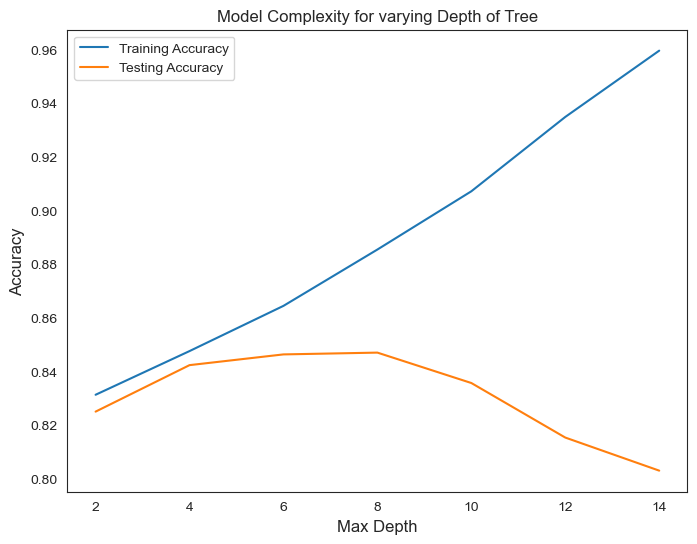

In [116]:
plt.figure(figsize=(8, 6))
plt.title("Model Complexity for varying Depth of Tree")
plt.plot(val, train_accuracies.values(), label="Training Accuracy")
plt.plot(val, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Max Depth", size= 12)
plt.ylabel('Accuracy', size= 12)
plt.show()

In [117]:
print(dt_gridsearch.best_params_)

{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__max_leaf_nodes': 30, 'decisiontreeclassifier__min_samples_split': 3}


In [118]:
dt_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),
                  DecisionTreeClassifier(random_state=32,
                     min_samples_split=3, max_leaf_nodes=30,
                    max_depth= 10,criterion='entropy'   ))

In [119]:
dt_clf= dt_clf.fit(X_train,y_train)

In [120]:
with open('dt_pkl', 'wb') as files:
    pickle.dump(dt_clf, files)

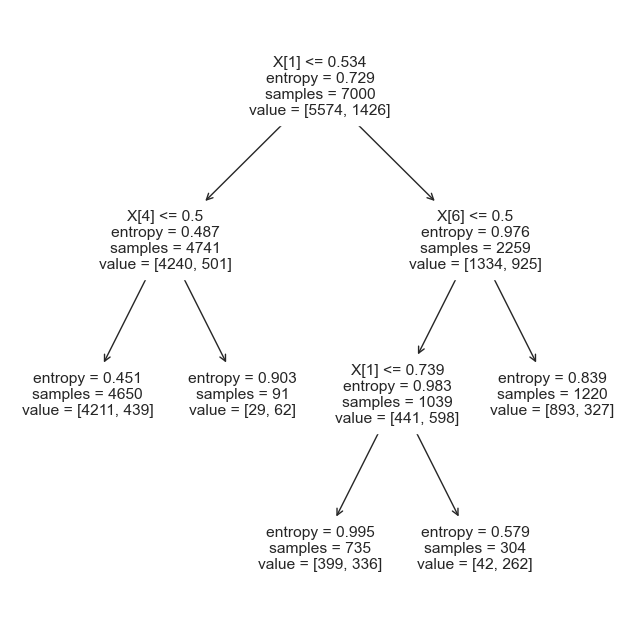

In [121]:
from sklearn import tree
clf=DecisionTreeClassifier(random_state=32, min_samples_split=3, max_leaf_nodes= 5,criterion='entropy'   )
clf = clf.fit(X_train,y_train)
fig = plt.figure(figsize=(8,8))
tree.plot_tree(clf)
plt.show()

## Ensemble Methods

## 1.Random Forest Model

In [122]:
rf_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),RandomForestClassifier())

In [123]:
rf_param_grid = { 'randomforestclassifier__n_estimators' : [50, 100, 150,200],
                 'randomforestclassifier__max_features' : ['sqrt','log2' ,0.33],
                 'randomforestclassifier__min_samples_leaf' : [1, 5 ,10, 15,20],
                 'randomforestclassifier__criterion' : ['gini', 'entropy'],
                 'randomforestclassifier__min_samples_split' : [3, 4,5],
                 'randomforestclassifier__max_depth': [4,6,8,10]
}
rf_gridsearch = GridSearchCV(rf_model, rf_param_grid, verbose=3, cv= 5, scoring='accuracy', n_jobs=-1)

In [124]:
rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [4, 6, 8, 10],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2',
                                                                  0.33],
                         'randomforestclassifier__min_samples_leaf': [1, 5, 10,
                                                                      15, 20],
                         'randomforestclassifier__min_samples_split': [3, 4, 5],
                         'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                  200]},
             scoring='accuracy', verbose=3)

In [125]:
rf_results = pd.DataFrame(rf_gridsearch.cv_results_['params'])

In [126]:
rf_results['test_score'] = rf_gridsearch.cv_results_['mean_test_score']

In [127]:
rf_results.head()

,randomforestclassifier__criterion,randomforestclassifier__max_depth,randomforestclassifier__max_features,randomforestclassifier__min_samples_leaf,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,test_score
0,gini,4,sqrt,1,3,50,0.796714
1,gini,4,sqrt,1,3,100,0.798000
2,gini,4,sqrt,1,3,150,0.798000
3,gini,4,sqrt,1,3,200,0.797714
4,gini,4,sqrt,1,4,50,0.798143


In [128]:
mean_fit_time= rf_gridsearch.cv_results_['mean_fit_time']
mean_score_time= rf_gridsearch.cv_results_['mean_score_time']
n_splits  = rf_gridsearch.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(rf_gridsearch.cv_results_).shape[0] #Iterations per split

print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter/3600)

1.7192940119902294


In [129]:
train_accuracies = {}
test_accuracies = {}
val = [2,4,6,8,10,12,14]
for v in val:    
    dtt = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),RandomForestClassifier(min_samples_split=4,
                                                                                        min_samples_leaf= 1 ,
                                                                                        max_features= 'sqrt',
                                                                                         n_estimators= 200 ,
                                                                                          max_depth = v,
                                                                                      criterion='gini'   ))  
    dtt.fit(X_train, y_train)    
    train_accuracies[v] = dtt.score(X_train, y_train)    
    test_accuracies[v] = dtt.score(X_test, y_test)


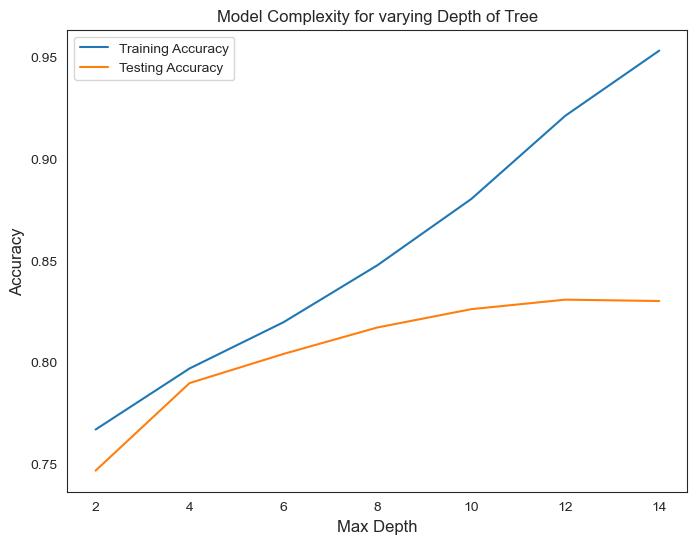

In [130]:
plt.figure(figsize=(8, 6))
plt.title("Model Complexity for varying Depth of Tree")
plt.plot(val, train_accuracies.values(), label="Training Accuracy")
plt.plot(val, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Max Depth", size= 12)
plt.ylabel('Accuracy', size= 12)
plt.show()

In [131]:
print(rf_gridsearch.best_params_)

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 50}


In [132]:
rf_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),RandomForestClassifier(min_samples_split=5,
                                                                                        min_samples_leaf= 1 ,
                                                                                        max_features= 0.33,
                                                                                         n_estimators= 200 ,
                                                                                          max_depth = 10,
                                                                                      criterion='entropy'   ))

In [133]:
rf_clf= rf_clf.fit(X_train,y_train)

In [134]:
import pickle

In [135]:
with open('rf_pkl', 'wb') as files:
    pickle.dump(rf_clf, files)

## 2. Gradient Boosting

In [136]:
gb_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),GradientBoostingClassifier())

In [137]:
gb_param_grid = { 'gradientboostingclassifier__n_estimators' : [50, 100, 150,200],
                 'gradientboostingclassifier__learning_rate':[0.001,0.1,0.3,0.5,0.7],
                 'gradientboostingclassifier__max_depth' : [2,4,5],
                 'gradientboostingclassifier__criterion' : ['friedman_mse', 'squared_error', 'mse'],
                 'gradientboostingclassifier__min_samples_split' : [3, 4,5],
                'gradientboostingclassifier__max_features':[ 'sqrt', 'log2']
}
gb_gridsearch = GridSearchCV(gb_model, gb_param_grid, verbose=3, cv= 5, scoring='accuracy', n_jobs=-1)

In [138]:
gb_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'squared_error',
                                                                   'mse'],
                         'gradientboostingclassifier__learning_rate': [0.001,
                                                                       0.1, 0.3,
                                                                       0.5,
                                                                       0.7],
                         'gradientboostingclassifier__max_depth': [2, 4, 5],
                         'gradientboostingclassifier__max_features': ['sqrt',
                                                                      'log2'],
                         'gradientboostingclassifier__min_samples_split': [3, 4,
                                                                           5],
                         'gradientboostingclassifier__n_estimators': [50, 100,
                                                                      150,
                                                                      200]},
             scoring='accuracy', verbose=3)

In [139]:
gb_results = pd.DataFrame(gb_gridsearch.cv_results_['params'])

In [140]:
gb_results['test_score'] = gb_gridsearch.cv_results_['mean_test_score']

In [141]:
gb_gridsearch.cv_results_['mean_score_time']

array([0.0016016 , 0.0024003 , 0.00319891, ..., 0.00379906, 0.0043992 ,
       0.00520024])

In [142]:
mean_fit_time= gb_gridsearch.cv_results_['mean_fit_time']
mean_score_time= gb_gridsearch.cv_results_['mean_score_time']
n_splits  = gb_gridsearch.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(gb_gridsearch.cv_results_).shape[0] #Iterations per split

print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter/3600)


1.0571233461962806


In [143]:
gb_results

,gradientboostingclassifier__criterion,gradientboostingclassifier__learning_rate,gradientboostingclassifier__max_depth,gradientboostingclassifier__max_features,gradientboostingclassifier__min_samples_split,gradientboostingclassifier__n_estimators,test_score
0,friedman_mse,0.001,2,sqrt,3,50,0.776429
1,friedman_mse,0.001,2,sqrt,3,100,0.779000
2,friedman_mse,0.001,2,sqrt,3,150,0.774143
3,friedman_mse,0.001,2,sqrt,3,200,0.776857
4,friedman_mse,0.001,2,sqrt,4,50,0.776286
...,...,...,...,...,...,...,...
1075,mse,0.700,5,log2,4,200,0.823857
1076,mse,0.700,5,log2,5,50,0.829571
1077,mse,0.700,5,log2,5,100,0.826000
1078,mse,0.700,5,log2,5,150,0.832571


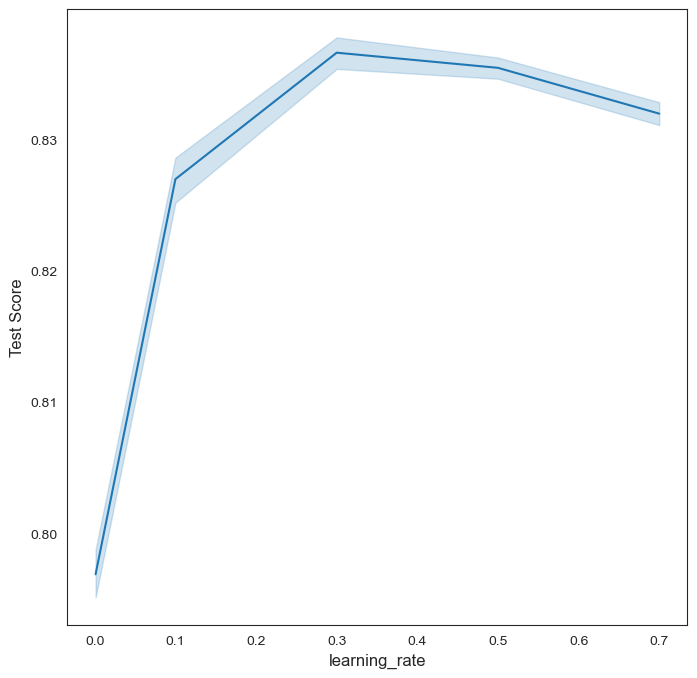

In [144]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.lineplot(data= gb_results,x='gradientboostingclassifier__learning_rate',y='test_score')
plt.xlabel('learning_rate', size= 12)
plt.ylabel('Test Score', size= 12)
plt.show()

In [145]:
print(gb_gridsearch.best_params_)

{'gradientboostingclassifier__criterion': 'friedman_mse', 'gradientboostingclassifier__learning_rate': 0.3, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 150}


In [146]:
gb_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),GradientBoostingClassifier(random_state=32,
n_estimators= 150,min_samples_split= 5,max_features= 'log2',max_depth= 4,learning_rate= 0.3,
criterion= 'friedman_mse'))

In [147]:
gb_clf= gb_clf.fit(X_train,y_train)

In [148]:
gb_clf

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                                            min_samples_split=5,
                                            n_estimators=150,
                                            random_state=32))])

In [149]:
with open('gb_pkl', 'wb') as files:
    pickle.dump(gb_clf, files)

## 3. Ada Boosting

In [150]:
ada_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),AdaBoostClassifier())

In [151]:
ada_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smote', 'adaboostclassifier', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'adaboostclassifier__algorithm', 'adaboostclassifier__base_estimator', 'adaboostclassifier__learning_rate', 'adaboostclassifier__n_estimators', 'adaboostclassifier__random_state'])

In [152]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [153]:
ada_param_grid = { 'adaboostclassifier__n_estimators' : [50, 100, 150,200],
                 'adaboostclassifier__learning_rate':[0.001,0.1,0.3,0.5,0.7]}
ada_gridsearch = GridSearchCV(ada_model, ada_param_grid, verbose=3, cv= 5, scoring='accuracy', n_jobs=-1)

In [154]:
ada_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'adaboostclassifier__learning_rate': [0.001, 0.1, 0.3,
                                                               0.5, 0.7],
                         'adaboostclassifier__n_estimators': [50, 100, 150,
                                                              200]},
             scoring='accuracy', verbose=3)

In [155]:
ada_results = pd.DataFrame(ada_gridsearch.cv_results_['params'])

In [156]:
ada_results['test_score'] = ada_gridsearch.cv_results_['mean_test_score']

In [157]:
ada_results

,adaboostclassifier__learning_rate,adaboostclassifier__n_estimators,test_score
0,0.001,50,0.728143
1,0.001,100,0.728143
2,0.001,150,0.728143
3,0.001,200,0.728143
4,0.100,50,0.797857
5,0.100,100,0.789714
6,0.100,150,0.795143
7,0.100,200,0.797143
8,0.300,50,0.797429
9,0.300,100,0.802714


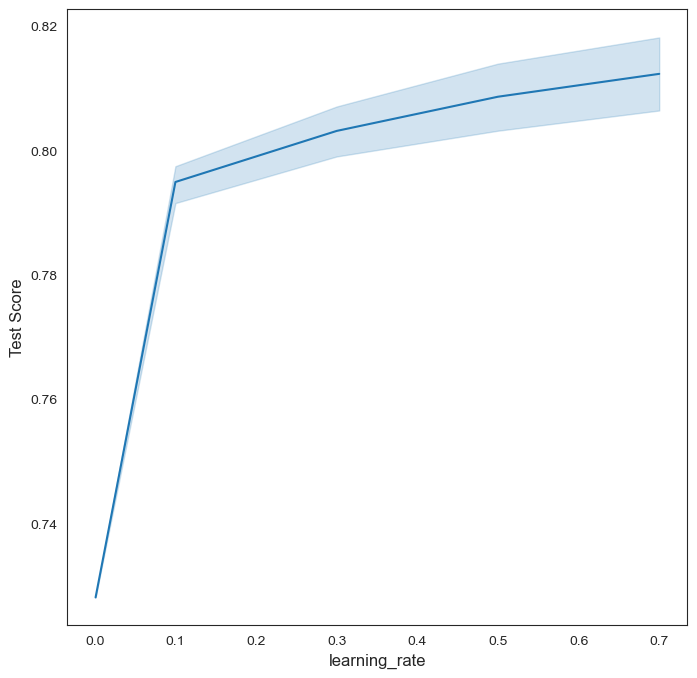

In [158]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.lineplot(data= ada_results,y='test_score',x='adaboostclassifier__learning_rate')
plt.xlabel('learning_rate', size= 12)
plt.ylabel('Test Score', size= 12)
plt.show()

In [159]:
mean_fit_time= ada_gridsearch.cv_results_['mean_fit_time']
mean_score_time= ada_gridsearch.cv_results_['mean_score_time']
n_splits  = ada_gridsearch.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(ada_gridsearch.cv_results_).shape[0] #Iterations per split

print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter/60)

1.413949195543925


In [160]:
print(ada_gridsearch.best_params_)

{'adaboostclassifier__learning_rate': 0.7, 'adaboostclassifier__n_estimators': 200}


In [161]:
ada_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),AdaBoostClassifier(random_state=32,
n_estimators= 200,learning_rate= 0.7))

In [162]:
ada_clf = ada_clf.fit(X_train,y_train)

In [163]:
ada_clf

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.7, n_estimators=200,
                                    random_state=32))])

In [164]:
with open('ada_pkl', 'wb') as files:
    pickle.dump(ada_clf, files)

## 4. XgBoost 

In [43]:
xgboost_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),xgb.XGBClassifier(random_state=32))

xgboost_model

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=32, ...))])

In [166]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [44]:
param_grid = {'xgbclassifier__gamma': [0,0.2,0.3, 0.5,0.7, 0.8,1],
              'xgbclassifier__max_depth': [3, 4, 5,7,6,8,9,10],
              'xgbclassifier__n_estimators': [50, 100,150, 200],
             'xgbclassifier__eta': np.linspace(0.01,0.2,5)
        }
xgb_gridsearch = GridSearchCV(xgboost_model, param_grid, verbose=3, cv= 5, n_jobs=-1, scoring='f1_macro')

In [45]:
xgb_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      imp...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=32, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__eta': array([0.01  , 0.0575, 0.105 , 0.1525, 0.2   ]),
                         'xgbclassifier__gamma': [0, 0.2, 0.3, 0.5, 0.7, 0.8,
                                                  1],
                         'xgbclassifier__max_depth': [3, 4, 5, 7, 6, 8, 9, 10],
                         'xgbclassifier__n_estimators': [50, 100, 150, 200]},
             scoring='f1_macro', verbose=3)

In [46]:
xgb_results = pd.DataFrame(xgb_gridsearch.cv_results_['params'])

In [47]:
xgb_results['test_score'] = xgb_gridsearch.cv_results_['mean_test_score']

In [48]:
xgb_results

,xgbclassifier__eta,xgbclassifier__gamma,xgbclassifier__max_depth,xgbclassifier__n_estimators,test_score
0,0.01,0.0,3,50,0.725621
1,0.01,0.0,3,100,0.730289
2,0.01,0.0,3,150,0.732385
3,0.01,0.0,3,200,0.738537
4,0.01,0.0,4,50,0.735093
...,...,...,...,...,...
1115,0.20,1.0,9,200,0.751017
1116,0.20,1.0,10,50,0.748400
1117,0.20,1.0,10,100,0.749097
1118,0.20,1.0,10,150,0.748166


<function matplotlib.pyplot.show(close=None, block=None)>

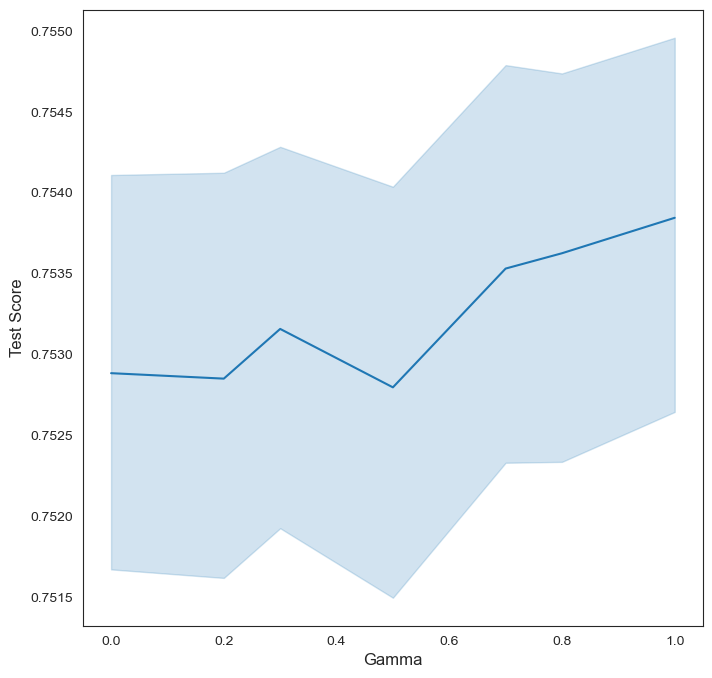

In [49]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.lineplot(data= xgb_results,y='test_score',x='xgbclassifier__gamma')
plt.xlabel('Gamma', size= 12)
plt.ylabel('Test Score', size= 12)
plt.show

In [55]:
mean_fit_time= xgb_gridsearch.cv_results_['mean_fit_time']
mean_score_time= xgb_gridsearch.cv_results_['mean_score_time']
n_splits  = xgb_gridsearch.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(xgb_gridsearch.cv_results_).shape[0] #Iterations per split

print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter/3600)

1.9251359367370604


In [51]:
print(xgb_gridsearch.best_params_)

{'xgbclassifier__eta': 0.2, 'xgbclassifier__gamma': 0.7, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 150}


In [52]:
xgb_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),xgb.XGBClassifier(random_state=32,
                                                                                   n_estimators =50,
                                                                                  max_depth= 4,
                                                                                    gamma = 0.7 ))

In [53]:
xgb_clf = xgb_clf.fit(X_train,y_train)

In [54]:
xgb_clf

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.7, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=4, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=32, ...))])

In [178]:
with open('xgb_pkl', 'wb') as files:
    pickle.dump(xgb_clf, files)

## SVC

In [179]:
svc_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),SVC(random_state=32))

svc_model

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('svc', SVC(random_state=32))])

In [180]:
param_grid = {'svc__kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
              'svc__C': [0.0005,0.001, 0.01, 0.1, 0.5],
              'svc__gamma': [1, 0.1, 0.01]}
svc_randomsearch = RandomizedSearchCV(svc_model, param_grid, verbose=3, cv= 5, n_jobs=-1, scoring='accuracy')

In [181]:
svc_randomsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                             ('svc', SVC(random_state=32))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': [0.0005, 0.001, 0.01, 0.1,
                                                   0.5],
                                        'svc__gamma': [1, 0.1, 0.01],
                                        'svc__kernel': ['linear', 'rbf', 'poly',
                                                        'sigmoid']},
                   scoring='accuracy', verbose=3)

In [182]:
svc_results = pd.DataFrame(svc_randomsearch.cv_results_['params'])

In [183]:
svc_results['test_score'] = svc_randomsearch.cv_results_['mean_test_score']

In [184]:
svc_results

,svc__kernel,svc__gamma,svc__C,test_score
0,rbf,0.10,0.0010,0.687571
1,linear,1.00,0.0010,0.701429
2,rbf,0.01,0.0010,0.685286
3,rbf,0.01,0.0005,0.685286
4,sigmoid,1.00,0.0100,0.762286
5,sigmoid,1.00,0.0010,0.639714
6,linear,0.10,0.0010,0.701429
7,rbf,1.00,0.5000,0.776143
8,linear,0.01,0.0005,0.685286
9,rbf,1.00,0.1000,0.758000


<function matplotlib.pyplot.show(close=None, block=None)>

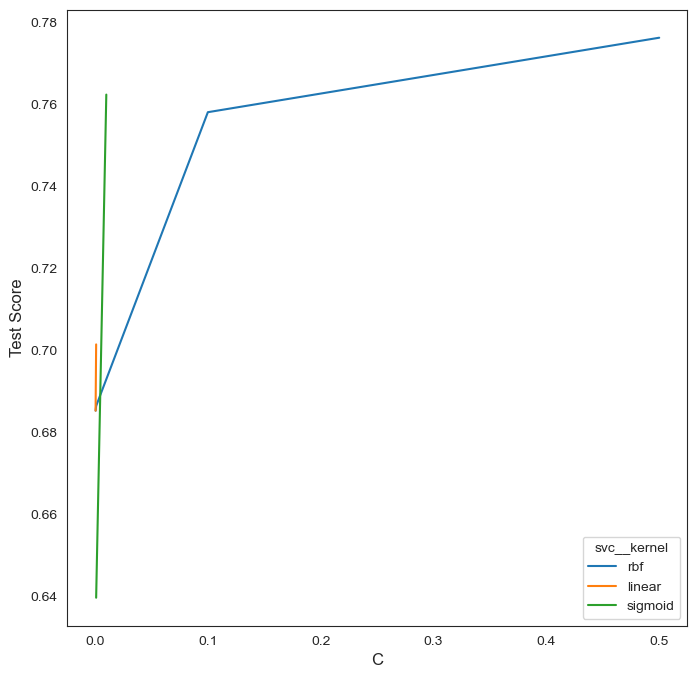

In [185]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.lineplot(data= svc_results,x='svc__C',y='test_score',hue='svc__kernel')
plt.xlabel('C', size= 12)
plt.ylabel('Test Score', size= 12)
plt.show

In [186]:
print(svc_randomsearch.best_params_)

{'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__C': 0.5}


In [187]:
svc_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),SVC(random_state=32,kernel= 'poly',
                                                                        gamma= 0.1, C= 0.5))
 

In [188]:
svc_clf= svc_clf.fit(X_train,y_train)

In [189]:
svc_clf

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('svc', SVC(C=0.5, gamma=0.1, kernel='poly', random_state=32))])

In [190]:
with open('svc_pkl', 'wb') as files:
    pickle.dump(svc_clf, files)

##  Naive Bayes Classfier

In [191]:
gnb_model = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),PowerTransformer(),GaussianNB())

gnb_model

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('powertransformer', PowerTransformer()),
                ('gaussiannb', GaussianNB())])

In [192]:
params_NB = {'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)}

gnb_randomsearch = RandomizedSearchCV(gnb_model, params_NB, verbose=1, cv= 5, n_jobs=-1, scoring='accuracy')

In [193]:
gnb_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smote', 'powertransformer', 'gaussiannb', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'powertransformer__copy', 'powertransformer__method', 'powertransformer__standardize', 'gaussiannb__priors', 'gaussiannb__var_smoothing'])

In [194]:
gnb_randomsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                             ('powertransformer',
                                              PowerTransformer()),
                                             ('gaussiannb', GaussianNB())]),
                   n_jobs=-1,
                   param_distributions={'gaussiannb__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   scoring='accuracy', verbose=1)

In [195]:
gnb_results = pd.DataFrame(gnb_randomsearch.cv_results_['params'])

In [196]:
gnb_results['test_score'] = gnb_randomsearch.cv_results_['mean_test_score']

In [197]:
gnb_results

,gaussiannb__var_smoothing,test_score
0,1.519911e-09,0.712000
1,2.848036e-03,0.712143
2,8.111308e-08,0.712000
3,5.336699e-03,0.712000
4,6.579332e-07,0.712000
5,2.310130e-05,0.712000
6,1.000000e-06,0.712000
7,1.232847e-04,0.712000
8,6.579332e-06,0.712000
9,1.232847e-05,0.712000


In [198]:
print(gnb_randomsearch.best_params_)

{'gaussiannb__var_smoothing': 0.002848035868435802}


In [199]:
gnb_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),PowerTransformer(),GaussianNB(var_smoothing= 0.0001873817422860383))
 

In [200]:
gnb_clf=gnb_clf.fit(X_train,y_train)

In [201]:
with open('gnb_pkl', 'wb') as files:
    pickle.dump(gnb_clf, files)

## Perceptron

In [202]:
perceptron_model= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),Perceptron())
 

In [203]:
perceptron_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smote', 'perceptron', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'perceptron__alpha', 'perceptron__class_weight', 'perceptron__early_stopping', 'perceptron__eta0', 'perceptron__fit_intercept', 'perceptron__l1_ratio', 'perceptron__max_iter', 'perceptron__n_iter_no_change', 'perceptron__n_jobs', 'perceptron__penalty', 'perceptron__random_state', 'perceptron__shuffle', 'perceptron__tol', 'perceptron__validation_fraction', 'perceptron__verbose', 'perceptron__warm_start'])

In [204]:
params_perceptron = {'perceptron__eta0': [0.0001, 0.001, 0.01, 0.1, 1.0]}

In [205]:
perceptron_gridsearch = GridSearchCV(perceptron_model,params_perceptron, scoring='accuracy', verbose=1, cv= 5, n_jobs=-1)

In [206]:
perceptron_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=32)),
                                       ('perceptron', Perceptron())]),
             n_jobs=-1,
             param_grid={'perceptron__eta0': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             scoring='accuracy', verbose=1)

In [207]:
perceptron_results = pd.DataFrame(perceptron_gridsearch.cv_results_['params'])

In [208]:
perceptron_results['test_score'] = perceptron_gridsearch.cv_results_['mean_test_score']

In [209]:
perceptron_results

,perceptron__eta0,test_score
0,0.0001,0.727000
1,0.0010,0.727000
2,0.0100,0.727000
3,0.1000,0.727000
4,1.0000,0.656857


In [210]:
print(perceptron_gridsearch.best_params_)

{'perceptron__eta0': 0.0001}


In [211]:
perceptron_clf= imbl_pipe(SMOTE(sampling_strategy='auto', random_state=32),Perceptron(eta0=0.0001))

In [212]:
perceptron_clf= perceptron_clf.fit(X_train, y_train)

In [213]:
with open('perceptron_pkl', 'wb') as files:
    pickle.dump(perceptron_clf, files)